In [1]:
import csv
import pandas as pd
from nltk import download
download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juseimandi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
import os
name=os.listdir('presidents-speeches/')
Dic={}
for i in name:
    SpeechBy=os.listdir('presidents-speeches/'+i+'/speeches')
    Dic[i]=SpeechBy



In [4]:
f = open('test101.csv', 'w')
c=0
with f:
    
    fnames = ['index','speech', 'name']
    wtt = csv.DictWriter(f, fieldnames=fnames)    

    wtt.writeheader()

    for k in Dic.keys():
        print(k)
        l=Dic[k]
        for i in range(len(l)):
            pth=l[i]
            E=open("presidents-speeches/"+str(k)+"/speeches/"+str(pth))
            w=E.readlines()
            wtt.writerow({'index':c,'speech' : w, 'name': k})
            c=c+1




George Washington
George W. Bush
George H. W. Bush
Barack Obama
Andrew Jackson
Donald Trump
Bill Clinton
Thomas Jefferson
Franklin D.Roosevelt
Ronald Reagan
Richard M. Nixon


In [5]:
df4=pd.read_csv("test101.csv",index_col="index")
df4.head(5)

,speech,name
index,,
0,['b\' Gentlemen of the House of Representative...,George Washington
1,"[""b'I trust I do not deceive myself when I ind...",George Washington
2,"['b"" Fellow Citizens of the Senate and House o...",George Washington
3,['b\'Whereas combinations to defeat the execut...,George Washington
4,['b\' Fellow Citizens of the Senate and of the...,George Washington


In [6]:
df4['President_id'] = df4['name'].factorize()[0]
president_id_df = df4[['name', 'President_id']].drop_duplicates().sort_values('President_id')
president_to_id = dict(president_id_df.values)
id_to_president = dict(president_id_df[['President_id', 'name']].values)
df4.head(10)

,speech,name,President_id
index,,,
0,['b\' Gentlemen of the House of Representative...,George Washington,0
1,"[""b'I trust I do not deceive myself when I ind...",George Washington,0
2,"['b"" Fellow Citizens of the Senate and House o...",George Washington,0
3,['b\'Whereas combinations to defeat the execut...,George Washington,0
4,['b\' Fellow Citizens of the Senate and of the...,George Washington,0
5,"[""b' Whereas I have received authentic informa...",George Washington,0
6,"[""b' I meet you, upon the present occasion, wi...",George Washington,0
7,"[""b'Fellow-Citizens:\\n\\nI am again called up...",George Washington,0
8,"[""b' Whereas it appears that a state of war ex...",George Washington,0


In [9]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df4['speech'] = df4['speech'].str.replace('b ', '')
df4['speech'] = df4['speech'].str.replace('hexe2x80x99s', '')
df4['speech'] = df4['speech'].str.replace('xc2xa0', '')
df4['speech'] = df4['speech'].str.replace('\xe2', '')
df4['speech'] = df4['speech'].str.replace('\x80', '')
df4['speech'] = df4['speech'].str.replace('\x99s', '')
df4['speech'] = df4['speech'].str.replace('\xa0We', '')
df4['speech'] = df4['speech'].apply(clean_text)
 
df4.head(10)

,speech,name,President_id
index,,,
0,gentlemen house representatives utmost attenti...,George Washington,0
1,bi trust deceive indulge persuasion never met ...,George Washington,0
2,fellow citizens senate house representatives r...,George Washington,0
3,bwhereas combinations defeat execution laws la...,George Washington,0
4,fellow citizens senate house representatives c...,George Washington,0
5,whereas received authentic information certain...,George Washington,0
6,meet upon present occasion feelings naturally ...,George Washington,0
7,bfellowcitizensnni called upon voice country e...,George Washington,0
8,whereas appears state war exists austria pruss...,George Washington,0


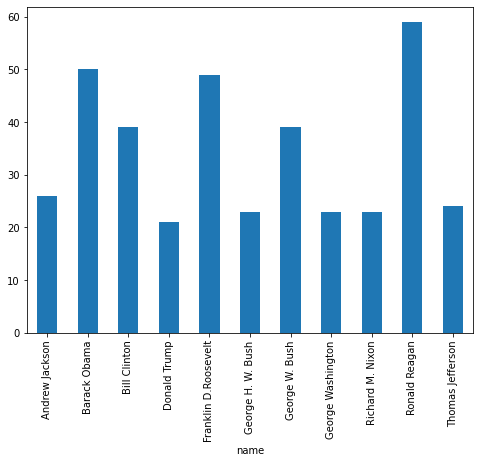

In [11]:
#repartiton of data by preseident to see if it is equally repartiton
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df4.groupby('name').speech.count().plot.bar(ylim=0)
plt.show()


# Find which moel is the best for us

In [12]:
#min_df is the minimum numbers of documents a word must be present in to be kept.
#norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
#ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=15, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df4.speech).toarray()
labels = df4.President_id
features.shape

(376, 4991)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

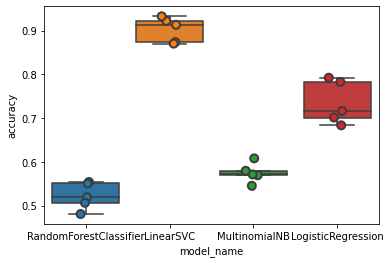

In [15]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.902220
LogisticRegression        0.735175
MultinomialNB             0.574864
RandomForestClassifier    0.522353
Name: accuracy, dtype: float64

In [ ]:
#here the best model is LinearSVC  so we will select this one to continue

In [17]:
# train and classify using best Classifier model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df4['speech'], df4['name'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)

In [18]:
txt=df4['speech'][240]
print(clf.predict(count_vect.transform([txt])))

['Thomas Jefferson']


In [19]:
df4[df4['speech']== txt]

,speech,name,President_id
index,,,
240,gentleman received remonstrance pleased addres...,Thomas Jefferson,7


In [ ]:
#on train le model et on plot la correlation entre actuel et predit pour voir sur quel president le model marche le mieux

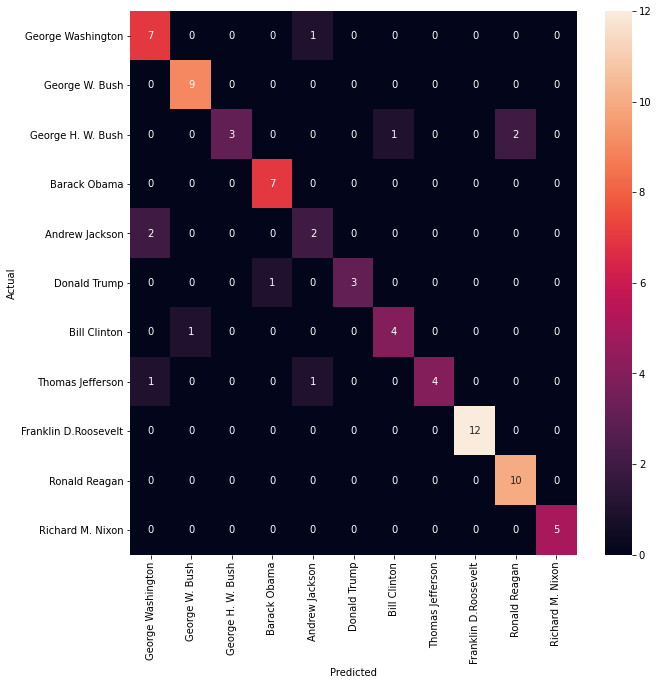

In [25]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df4.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=president_id_df.name.values, yticklabels=president_id_df.name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
import numpy as np
model.fit(features, labels)
N = 2
for name, president_id in sorted(president_to_id.items()):
    indices = np.argsort(model.coef_[president_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(name))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'Andrew Jackson':
  . Top unigrams:
       . duties
       . removal
  . Top bigrams:
       . general government
       . public money
# 'Barack Obama':
  . Top unigrams:
       . xc2xa0
       . thatxe2x80x99s
  . Top bigrams:
       . applause xc2xa0
       . laughter xc2xa0
# 'Bill Clinton':
  . Top unigrams:
       . ought
       . bosnia
  . Top bigrams:
       . fellow americans
       . 21st century
# 'Donald Trump':
  . Top unigrams:
       . incredible
       . beautiful
  . Top bigrams:
       . thank applause
       . want thank
# 'Franklin D.Roosevelt':
  . Top unigrams:
       . italy
       . civilization
  . Top bigrams:
       . army navy
       . purchasing power
# 'George H. W. Bush':
  . Top unigrams:
       . kuwait
       . panama
  . Top bigrams:
       . new world
       . let tell
# 'George W. Bush':
  . Top unigrams:
       . appreciate
       . terrorists
  . Top bigrams:
       . weapons mass
       . september 11th
# 'George Washington':
  . Top unigrams:

In [26]:
#see how good is our model
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df4['name'].unique()))

                      precision    recall  f1-score   support

   George Washington       0.70      0.88      0.78         8
      George W. Bush       0.90      1.00      0.95         9
   George H. W. Bush       1.00      0.50      0.67         6
        Barack Obama       0.88      1.00      0.93         7
      Andrew Jackson       0.50      0.50      0.50         4
        Donald Trump       1.00      0.75      0.86         4
        Bill Clinton       0.80      0.80      0.80         5
    Thomas Jefferson       1.00      0.67      0.80         6
Franklin D.Roosevelt       1.00      1.00      1.00        12
       Ronald Reagan       0.83      1.00      0.91        10
    Richard M. Nixon       1.00      1.00      1.00         5

           micro avg       0.87      0.87      0.87        76
           macro avg       0.87      0.83      0.84        76
        weighted avg       0.88      0.87      0.86        76



In [87]:
#observer ou les prediction ont eu faux pour ameliorer le model
for predicted in president_id_df.President_id:
    for actual in president_id_df.President_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_president[actual], id_to_president[predicted], conf_mat[actual, predicted]))
            display(df4.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['name', 'speech']])
            print('')

'Andrew Jackson' predicted as 'George Washington' : 2 examples.


,name,speech
index,,
142,Andrew Jackson,bwhereas act congress united states 7th januar...
150,Andrew Jackson,bwhereas act congress united states passed 29t...



'George H. W. Bush' predicted as 'Ronald Reagan' : 2 examples.


,name,speech
index,,
76,George H. W. Bush,bmy fellow citizens last night ordered us mili...
65,George H. W. Bush,bmr speaker mr president distinguished members...
